# ------------------------------**Sung** Work Begins Here--------------------------------

# Importing from CSV file
## = CDC.gov Dataset =

### Gather dependencies

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
# from sodapy import Socrata
from config import census_key
import pprint
import requests
import os
import scipy.stats as st
from scipy.stats import linregress

### Create DataFrame for CDC Data

In [2]:
cdc_data = pd.read_csv("../Project_1/cdc_data.csv")
cdc_data
cdc_df = pd.DataFrame(cdc_data)
cdc_df

# Choose the columns we want and rename anything that isn't clear
cdc_df = cdc_df[['case_month', 'res_state', 'res_county', 'age_group', 'sex', 'race', 'ethnicity', 'current_status']]
cdc_df = cdc_df.rename(columns={
    'res_state': 'State',
    'res_county': 'County',
    'ethnicity': 'Ethnicity',
    'current_status': 'Infection Status',
    'race':'Race'
})

# Drop "Unkown" race from dataset
cdc_df = cdc_df.loc[cdc_df['Race']!= 'Unknown', :]

# Set Infections to 1 and replace the various races with values that are compatible with the census data
cdc_df['Infections'] = 1
cdc_df['Race'] = cdc_df['Race'].replace('White', 'Caucasian')
cdc_df['Race'] = cdc_df['Race'].replace('Black', 'African American')
cdc_df['Race'] = cdc_df['Race'].replace('American Indian/Alaska Native', 'Native American')
cdc_df['Race'] = cdc_df['Race'].replace('Multiple/Other', 'Other')
cdc_df['Race'] = np.where(np.logical_and(cdc_df['Race'] == 'Caucasian', cdc_df['Ethnicity'] == 'Hispanic/Latino'), 'Hispanic', cdc_df['Race'])

# NOTE: It's not clear what happens with Hawaiian here. 

cdc_df

,case_month,State,County,age_group,sex,Race,Ethnicity,Infection Status,Infections
0,2021-11,MN,STEELE,18 to 49 years,Male,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
2,2021-11,MN,STEARNS,50 to 64 years,Female,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
3,2020-05,MN,KANDIYOHI,18 to 49 years,Male,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
4,2021-05,MN,ANOKA,18 to 49 years,Male,NaN,NaN,Laboratory-confirmed case,1
5,2020-04,MN,CLAY,65+ years,Female,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
...,...,...,...,...,...,...,...,...,...
539745,2022-01,MN,SCOTT,50 to 64 years,Male,Asian,Non-Hispanic/Latino,Laboratory-confirmed case,1
539746,2020-11,MN,GOODHUE,18 to 49 years,Female,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
539747,2020-11,MN,DAKOTA,18 to 49 years,Male,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
539748,2022-01,MN,DAKOTA,50 to 64 years,Male,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1


## Infections by race in MN

In [3]:
# Drop NaNs and then sort by date chronologically
cdc_df = cdc_df.dropna(how='any')
cdc_df = cdc_df[['case_month', 'County', 'Race', 'Infections']]

cdc_df

,case_month,County,Race,Infections
0,2021-11,STEELE,Caucasian,1
2,2021-11,STEARNS,Caucasian,1
3,2020-05,KANDIYOHI,Caucasian,1
5,2020-04,CLAY,Caucasian,1
6,2020-10,NOBLES,Hispanic,1
...,...,...,...,...
539745,2022-01,SCOTT,Asian,1
539746,2020-11,GOODHUE,Caucasian,1
539747,2020-11,DAKOTA,Caucasian,1
539748,2022-01,DAKOTA,Caucasian,1


In [4]:
race_mn = cdc_df['Race'].unique()
race_mn = sorted(set(race_mn))
race_mn

['African American',
 'Asian',
 'Caucasian',
 'Hispanic',
 'Native American',
 'Other']

In [5]:
cdc_date = cdc_df['case_month'].unique()
cdc_date.sort()
print(cdc_date)

['2020-03' '2020-04' '2020-05' '2020-06' '2020-07' '2020-08' '2020-09'
 '2020-10' '2020-11' '2020-12' '2021-01' '2021-02' '2021-03' '2021-04'
 '2021-05' '2021-06' '2021-07' '2021-08' '2021-09' '2021-10' '2021-11'
 '2021-12' '2022-01' '2022-02' '2022-03' '2022-04' '2022-05' '2022-06']


In [6]:
cdc_date[0]

'2020-03'

In [7]:
# for date in cdc_date:
#     print(date)
# # you can try to append this date to the function .loc 

In [8]:
cdc_df = cdc_df.sort_values(['case_month', 'County'])
cdc_df

,case_month,County,Race,Infections
232369,2020-03,ANOKA,Caucasian,1
275945,2020-03,ANOKA,Caucasian,1
305881,2020-03,ANOKA,Caucasian,1
354490,2020-03,ANOKA,Caucasian,1
408125,2020-03,ANOKA,Caucasian,1
...,...,...,...,...
512646,2022-06,WRIGHT,Caucasian,1
528869,2022-06,WRIGHT,Caucasian,1
531029,2022-06,WRIGHT,Caucasian,1
534619,2022-06,WRIGHT,Caucasian,1


## Yearly- Year 2021

In [9]:
#filtering to 2020. bins function?
cdc_2021_list = ['2021-01', '2021-02', '2021-03', '2021-04','2021-05', '2021-06', '2021-07', '2021-08', '2021-09',
 '2021-10', '2021-11', '2021-12']

cdc_2021_df = cdc_df.loc[cdc_df['case_month'].isin(cdc_2021_list)]
cdc_2021_df


# cdc_2020_list = ['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09',
#  '2020-10', '2020-11', '2020-12']
# cdc_2022_list = ['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09',
#  '2020-10', '2020-11', '2020-12']

,case_month,County,Race,Infections
1421,2021-01,ANOKA,Caucasian,1
2045,2021-01,ANOKA,Caucasian,1
2147,2021-01,ANOKA,Caucasian,1
3381,2021-01,ANOKA,Caucasian,1
5137,2021-01,ANOKA,Asian,1
...,...,...,...,...
537356,2021-12,WRIGHT,Caucasian,1
538341,2021-12,WRIGHT,Caucasian,1
538493,2021-12,WRIGHT,Caucasian,1
538975,2021-12,WRIGHT,Caucasian,1


In [10]:
#total sum of infections of African American in 2021
cdc_2021_infections_african_american_df = cdc_2021_df.loc[  cdc_2021_df['Race'] == race_mn[0]]
cdc_2021_infections_african_american_df
cdc_2021_infections_african_american_df = cdc_2021_infections_african_american_df.groupby(['County', 'Race'])
cdc_2021_infections_african_american_df.head()
cdc_2021_infections_african_american_sum_df = cdc_2021_infections_african_american_df.sum()
cdc_2021_infections_african_american_sum_df.head(50)

,,Infections
County,Race,
ANOKA,African American,1134
BENTON,African American,48
BLUE EARTH,African American,35
CARVER,African American,26
CLAY,African American,22
DAKOTA,African American,1334
GOODHUE,African American,22
HENNEPIN,African American,7174
KANDIYOHI,African American,23


In [11]:
cdc_2021_infections_african_american_total = cdc_2021_infections_african_american_sum_df['Infections'].sum()
cdc_2021_infections_african_american_total

14374

In [12]:
#total sum of infections of asians in 2021
cdc_2021_infections_asian_df = cdc_2021_df.loc[  cdc_2021_df['Race'] == race_mn[1]]
cdc_2021_infections_asian_df
cdc_2021_infections_asian_df = cdc_2021_infections_asian_df.groupby(['County', 'Race'])
cdc_2021_infections_asian_df.head()
cdc_2021_infections_asian_sum_df = cdc_2021_infections_asian_df.sum()
cdc_2021_infections_asian_sum_df.head(50)

,,Infections
County,Race,
ANOKA,Asian,627
CARVER,Asian,48
DAKOTA,Asian,553
HENNEPIN,Asian,2582
MOWER,Asian,6
NOBLES,Asian,9
OLMSTED,Asian,113
RAMSEY,Asian,2162
RICE,Asian,2


In [13]:
cdc_2021_infections_asian_total = cdc_2021_infections_asian_sum_df['Infections'].sum()
cdc_2021_infections_asian_total

6836

In [14]:
#total sum of infections of asians in 2021
cdc_2021_infections_white_df = cdc_2021_df.loc[  cdc_2021_df['Race'] == race_mn[2]]
cdc_2021_infections_white_df
cdc_2021_infections_white_df = cdc_2021_infections_white_df.groupby(['County', 'Race'])
cdc_2021_infections_white_df.head()
cdc_2021_infections_white_sum_df = cdc_2021_infections_white_df.sum()
cdc_2021_infections_white_sum_df.head(50)

,,Infections
County,Race,
ANOKA,Caucasian,10978
BECKER,Caucasian,894
BELTRAMI,Caucasian,1095
BENTON,Caucasian,1697
BLUE EARTH,Caucasian,1919
BROWN,Caucasian,842
CARLTON,Caucasian,583
CARVER,Caucasian,3528
CASS,Caucasian,671


In [15]:
cdc_2021_infections_white_total = cdc_2021_infections_white_sum_df['Infections'].sum()
cdc_2021_infections_white_total

140423

In [16]:
#total sum of infections of asians in 2021
cdc_2021_infections_hispanic_df = cdc_2021_df.loc[  cdc_2021_df['Race'] == race_mn[3]]
cdc_2021_infections_hispanic_df
cdc_2021_infections_hispanic_df = cdc_2021_infections_hispanic_df.groupby(['County', 'Race'])
cdc_2021_infections_hispanic_df.head()
cdc_2021_infections_hispanic_sum_df = cdc_2021_infections_hispanic_df.sum()
cdc_2021_infections_hispanic_sum_df.head(50)

,,Infections
County,Race,
ANOKA,Hispanic,265
BLUE EARTH,Hispanic,14
CARVER,Hispanic,70
CLAY,Hispanic,16
DAKOTA,Hispanic,630
FREEBORN,Hispanic,34
HENNEPIN,Hispanic,1236
MCLEOD,Hispanic,41
MOWER,Hispanic,82


In [17]:
cdc_2021_infections_hispanic_total = cdc_2021_infections_hispanic_sum_df['Infections'].sum()
cdc_2021_infections_hispanic_total

3629

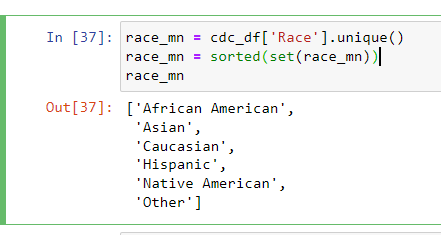

In [18]:
#total sum of infections of Native American in 2021
cdc_2021_infections_native_american_df = cdc_2021_df.loc[  cdc_2021_df['Race'] == race_mn[4]]
cdc_2021_infections_native_american_df
cdc_2021_infections_native_american_df = cdc_2021_infections_native_american_df.groupby(['County', 'Race'])
cdc_2021_infections_native_american_df.head()
cdc_2021_infections_native_american_sum_df = cdc_2021_infections_native_american_df.sum()
cdc_2021_infections_native_american_sum_df.head(50)

,,Infections
County,Race,
ANOKA,Native American,7
BECKER,Native American,109
BELTRAMI,Native American,546
CARLTON,Native American,14
CASS,Native American,100
DAKOTA,Native American,11
HENNEPIN,Native American,297
ITASCA,Native American,26
PINE,Native American,3


In [19]:
cdc_2021_infections_native_american_total = cdc_2021_infections_native_american_sum_df['Infections'].sum()
cdc_2021_infections_native_american_total

1298

In [20]:
#total sum of infections of other in 2021
cdc_2021_infections_other_df = cdc_2021_df.loc[  cdc_2021_df['Race'] == race_mn[5]]
cdc_2021_infections_other_df
cdc_2021_infections_other_df = cdc_2021_infections_other_df.groupby(['County', 'Race'])
cdc_2021_infections_other_df.head()
cdc_2021_infections_other_sum_df = cdc_2021_infections_other_df.sum()
cdc_2021_infections_other_sum_df.head(50)

,,Infections
County,Race,
ANOKA,Other,150
BELTRAMI,Other,21
CARVER,Other,9
CHISAGO,Other,5
CLAY,Other,13
DAKOTA,Other,262
GOODHUE,Other,3
HENNEPIN,Other,773
OLMSTED,Other,130


In [21]:
cdc_2021_infections_other_total = cdc_2021_infections_other_sum_df['Infections'].sum()
cdc_2021_infections_other_total

2166

In [22]:

total_infection_byrace_2021 = [cdc_2021_infections_african_american_total, cdc_2021_infections_asian_total, 
                               cdc_2021_infections_asian_total, cdc_2021_infections_hispanic_total, 
                               cdc_2021_infections_native_american_total, cdc_2021_infections_other_total]
for (race, infection) in zip(race_mn, total_infection_byrace_2021):
    print(f" {race}: {infection}")

 African American: 14374
 Asian: 6836
 Caucasian: 6836
 Hispanic: 3629
 Native American: 1298
 Other: 2166


In [ ]:
#infection rate per year (in units of months)
african_american_infection_percent = ((cdc_2021_infections_african_american_total / sum_mn_african_american / 12)
african_american_infection_percent


          
#           , cdc_2021_infections_asian_total, 
                               
#     cdc_2021_infections_asian_total, 
#     cdc_2021_infections_hispanic_total, 
                               
#         cdc_2021_infections_native_american_total, 
#         cdc_2021_infections_other_total
# print(sum_mn_pop)
# print(sum_mn_caucasian)
# print(sum_mn_african_american)
# print(sum_mn_native_american)
# print(sum_mn_asian)
# print(sum_mn_hawaiian)
# print(percent_mn_caucasian)
# print(percent_mn_african_american)
# print(percent_mn_native_american)
# print(percent_mn_asian)
# print(percent_mn_hawaiian)
# print(percent_mn_other)

In [ ]:
#infection rate per year (in units of months)
african_american_infection_percent = ((cdc_2021_infections_african_american_total / sum_mn_african_american / 12)
african_american_infection_percent

In [ ]:
asian_infection_percent = ((cdc_2021_infections_asian_total / sum_mn_asian) / 12)
asian_infection_percent

## Rate of infection by 3 months period

In [ ]:
#every three month
#2020
cdc_2020_march_may_list = ['2020-03', '2020-04', '2020-05']
cdc_2020_june_august_list = ['2020-06', '2020-07', '2020-08']
cdc_2020_sept_december_list = ['2020-09', '2020-10', '2020-11', '2020-12']

#2021
cdc_2021_jan_march_list = ['2021-01', '2021-02', '2021-03']
cdc_2021_april_june_list = ['2021-04', '2021-05', '2021-06']
cdc_2021_july_sept_list = ['2021-07', '2021-06', '2021-07']
cdc_2021_oct_dec_list = ['2021-10', '2021-11', '2021-12']

cdc_2020_march_may_df = cdc_df.loc[cdc_df['case_month'].isin(cdc_2020_march_may_list)]
cdc_2020_march_may_df

# cdc_2020_sept_december_df = cdc_df.loc[cdc_df['case_month'].isin(cdc_2020_sept_december_list)]
# cdc_2020_sept_december_df


In [ ]:
# #total sum of infections in 3 months by race.
# cdc_2020_march_may_infections_african_american_df = cdc_2020_march_may_df.loc[  cdc_2020_march_may_df['Race'] == race_mn[1]]
# cdc_2020_march_may_infections_african_american_df

In [ ]:
#total sum of infections in 3 months by race.
cdc_2020_march_may_infections_african_american_df = cdc_2020_march_may_df.loc[  cdc_2020_march_may_df['Race'] == race_mn[0]]
cdc_2020_march_may_infections_african_american_df
cdc_2020_march_may_infections_african_american_df = cdc_2020_march_may_infections_african_american_df.groupby(['County', 'Race'])
cdc_2020_march_may_infections_african_american_df.head()
cdc_2020_march_may_infections_african_american_sum_df = cdc_2020_march_may_infections_african_american_df.sum()
cdc_2020_march_may_infections_african_american_sum_df.head(50)

In [ ]:
cdc_2020_march_may_infections_african_american_total = cdc_2020_march_may_infections_african_american_sum_df['Infections'].sum()
cdc_2020_march_may_infections_african_american_total

In [ ]:
# cdc_2020_june_august_df = cdc_df.loc[cdc_df['case_month'].isin(cdc_2020_june_august_list)]
# cdc_2020_june_august_df

In [ ]:
#total sum of infections in 3 months by race.
cdc_2020_june_august_df = cdc_df.loc[cdc_df['case_month'].isin(cdc_2020_june_august_list)]
cdc_2020_june_august_df
cdc_2020_june_august_infections_african_american_df = cdc_2020_june_august_df.loc[  cdc_2020_june_august_df['Race'] == race_mn[0]]
cdc_2020_june_august_infections_african_american_df
cdc_2020_june_august_infections_african_american_df = cdc_2020_june_august_infections_african_american_df.groupby(['County', 'Race'])
cdc_2020_june_august_infections_african_american_df.head()
cdc_2020_june_august_infections_african_american_sum_df = cdc_2020_june_august_infections_african_american_df.sum()
cdc_2020_june_august_infections_african_american_sum_df.head(50)

In [ ]:
cdc_2020_june_august_infections_african_american_total = cdc_2020_june_august_infections_african_american_sum_df['Infections'].sum()
cdc_2020_june_august_infections_african_american_total

In [ ]:
#total sum of infections in 3 months by race.
cdc_2020_sept_december_df = cdc_df.loc[cdc_df['case_month'].isin(cdc_2020_sept_december_list)]
cdc_2020_sept_december_df

cdc_2020_sept_december_infections_african_american_df = cdc_2020_sept_december_df.loc[  cdc_2020_sept_december_df['Race'] == race_mn[0]]
cdc_2020_sept_december_infections_african_american_df
cdc_2020_sept_december_infections_african_american_df = cdc_2020_sept_december_infections_african_american_df.groupby(['County', 'Race'])
cdc_2020_sept_december_infections_african_american_df.head()
cdc_2020_sept_december_infections_african_american_sum_df = cdc_2020_sept_december_infections_african_american_df.sum()
cdc_2020_sept_december_infections_african_american_sum_df.head(50)

In [ ]:
cdc_2020_sept_december_infections_african_american_total = cdc_2020_sept_december_infections_african_american_sum_df['Infections'].sum()
cdc_2020_sept_december_infections_african_american_total
normalized_cdc_2020_sept_december_infections_african_american_percent = (cdc_2020_sdept_december_infections_african_american_total/354540)

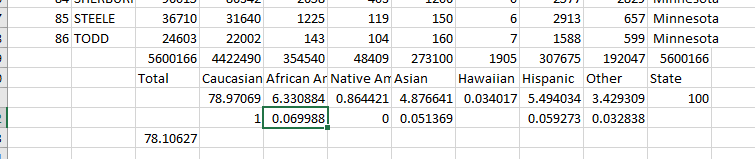

In [ ]:
# cdc_2021_jan_march_list
#total sum of infections in 3 months by race.
cdc_2021_jan_march_df = cdc_df.loc[cdc_df['case_month'].isin(cdc_2021_jan_march_list)]
cdc_2021_jan_march_df

cdc_2021_jan_march_infections_african_american_df = cdc_2021_jan_march_df.loc[  cdc_2021_jan_march_df['Race'] == race_mn[0]]
cdc_2021_jan_march_infections_african_american_df
cdc_2021_jan_march_infections_african_american_df = cdc_2021_jan_march_infections_african_american_df.groupby(['County', 'Race'])
cdc_2021_jan_march_infections_african_american_df.head()
cdc_2021_jan_march_infections_african_american_sum_df = cdc_2021_jan_march_infections_african_american_df.sum()
cdc_2021_jan_march_infections_african_american_sum_df.head(50)

In [ ]:
# cdc_2021__list
#total sum of infections in 3 months by race.
cdc_2021_april_june_df = cdc_df.loc[cdc_df['case_month'].isin(cdc_2021_april_june_list)]
cdc_2021_april_june_df

cdc_2021_april_june_infections_african_american_df = cdc_2021_april_june_df.loc[  cdc_2021_april_june_df['Race'] == race_mn[0]]
cdc_2021_april_june_infections_african_american_df
cdc_2021_april_june_infections_african_american_df = cdc_2021_april_june_infections_african_american_df.groupby(['County', 'Race'])
cdc_2021_april_june_infections_african_american_df.head()
cdc_2021_april_june_infections_african_american_sum_df = cdc_2021_april_june_infections_african_american_df.sum()
cdc_2021_april_june_infections_african_american_sum_df.head(50)

In [ ]:
#population by race infected with covid-19 from 2020-March thru 2022-June
cdc_byrace_df = cdc_df['Race'].value_counts()
cdc_byrace_df

In [ ]:
# print(percent_mn_caucasian)
# print(percent_mn_african_american)
# print(percent_mn_native_american)
# print(percent_mn_asian)
# print(percent_mn_hawaiian)
# print(percent_mn_other)

In [ ]:
# how to make a dataframe that it shows that it is arranged by date but shows number of infection with caucasian in anoka county.

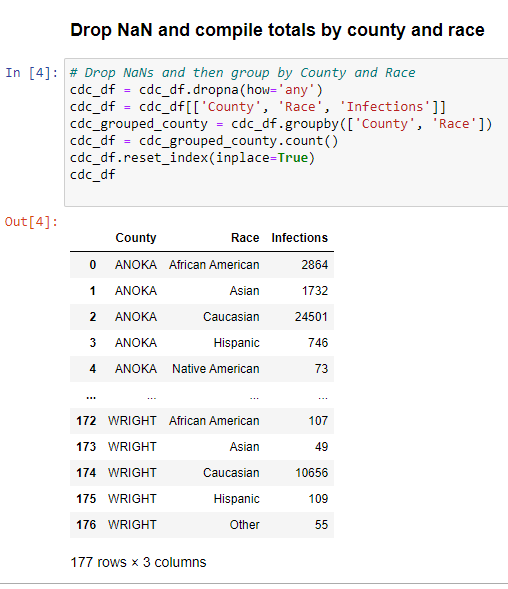

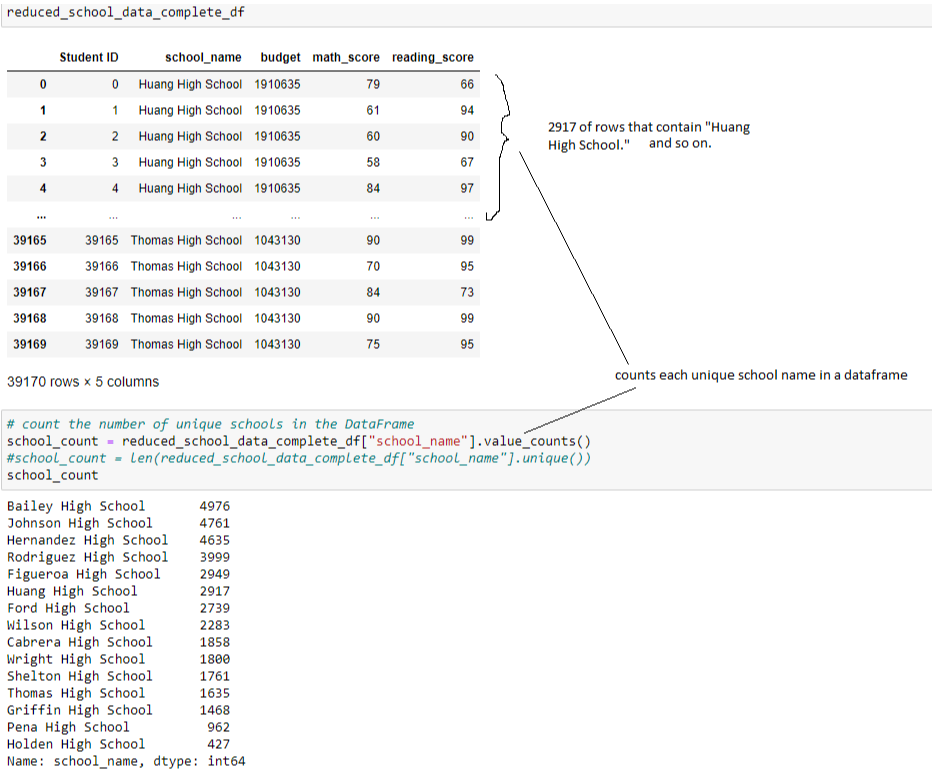

In [ ]:
for row in cdc_df:
    print(row)

In [ ]:
County = []
percent_caucasian = []
percent_caucasian = []
percent_caucasian = []
percent_caucasian
percent_caucasian

poverty_count = []
poverty_rate = []
county = []
state = []

for row in cdc_df:
        # Add place
        place.append(row[0])

        # Add population
        population.append(row[1])

        # Add per capita income
        income.append(row[4])

        # Add poverty count
        poverty_count.append(row[8])

        # Determine poverty rate to 2 decimal places, convert to string
        percent = round(int(row[8]) / int(row[1]) * 100, 2)
        poverty_rate.append(str(percent) + "%")

for date in cdc_date:
    cdc_2020_df = cdc_df.loc[cdc_df['case_month'] == date]
    list.append[]
    if date = '2021-01'
# # you can try to append this date to the function .loc 
# cdc_2020_03_df = cdc_df.loc[cdc_df['case_month'] == '2020-03']
# cdc_2020_03_df

In [ ]:
#setting to 2020-03
cdc_2020_03_df = cdc_df.loc[cdc_df['case_month'] == '2020-03']
cdc_2020_03_df

In [ ]:
cdc_2020_03_df['Race'].unique()

In [ ]:
cdc_2020_03_caucasian_df = cdc_2020_03_df.loc[    cdc_2020_03_df['Race'] == 'Caucasian'  ]
cdc_2020_03_african_american_df = cdc_2020_03_df.loc[    cdc_2020_03_df['Race'] == 'African American'  ]


In [ ]:
caucasian_count_2020_03 = cdc_2020_03_caucasian_df['Infections'].sum()
african_american_count_2020_03 = cdc_2020_03_african_american_df['Infections'].sum()

print(f" {caucasian_count_2020_03} Caucasians and {african_american_count_2020_03} African Americans were infected in March 2020.")

In [ ]:
#setting to 2020-04
cdc_2020_04_df = cdc_df.loc[cdc_df['case_month'] == '2020-04']
cdc_2020_04_df
cdc_2020_04_df['Race'].unique()

In [ ]:
cdc_2020_04_caucasian_df = cdc_2020_04_df.loc[    cdc_2020_04_df['Race'] == 'Caucasian'  ]
cdc_2020_04_african_american_df = cdc_2020_04_df.loc[    cdc_2020_04_df['Race'] == 'African American'  ]
cdc_2020_04_hispanic_df = cdc_2020_04_df.loc[    cdc_2020_04_df['Race'] == 'Hispanic'  ]
cdc_2020_04_asian_df = cdc_2020_04_df.loc[    cdc_2020_04_df['Race'] == 'Asian'  ]
cdc_2020_04_other_df = cdc_2020_04_df.loc[    cdc_2020_04_df['Race'] == 'Other'  ]

caucasian_count_2020_04 = cdc_2020_04_caucasian_df['Infections'].sum()
african_american_count_2020_04 = cdc_2020_04_african_american_df['Infections'].sum()
caucasian_count_2020_04 = cdc_2020_04_caucasian_df['Infections'].sum()
african_american_count_2020_04 = cdc_2020_04_african_american_df['Infections'].sum()
caucasian_count_2020_04 = cdc_2020_04_caucasian_df['Infections'].sum()
african_american_count_2020_04 = cdc_2020_04_african_american_df['Infections'].sum()

print(f" {caucasian_count_2020_04} Caucasians and {african_american_count_2020_04} African Americans were infected in March 2020.")


In [ ]:
#think about for loop. +1 month ..
cdc_anoka = cdc_df.loc[cdc_df['County'] == 'ANOKA']
cdc_anoka

In [ ]:
# Export the DataFrames to CSV

cdc_df.to_csv("output/cdc_df.csv", index=True)

In [ ]:
cdc_df = cdc_df.sort_values(['case_month'])
cdc_df

In [ ]:
cdc_df = cdc_df.sort_values(['County'])
cdc_df

In [ ]:
# Export the DataFrames to CSV

cdc_df.to_csv("output/cdc_df.csv", index=True)

In [ ]:
# I want to make it so that it does for loop and run all the counties and append it in a list. or groupit so that it shows
# the date chronologically and counties in order.
cdc_hennepin = cdc_df.loc[cdc_df['County'] == 'HENNEPIN']
cdc_hennepin

In [ ]:
cdc_grouped_county = cdc_df.groupby(['County'])
# cdc_grouped_county = cdc_df.groupby(['County', 'Race']
# cdc_df.reset_index(inplace=True)
cdc_df

In [ ]:
#export this and see how it is arranged. also how to calculate a rate.

In [ ]:
# cdc_grouped_county = cdc_df.groupby(['County', 'Race'])
# # cdc_grouped_county.head()
# cdc_df = cdc_grouped_county.sort_values(['case_month'])
# # cdc_df.reset_index(inplace=True)
# cdc_df


In [ ]:
# # Drop NaNs and then group by County and Race
# cdc_df = cdc_df.dropna(how='any')
# cdc_df = cdc_df[['case_month', 'County', 'Race', 'Infections']]
# cdc_grouped_county = cdc_df.groupby(['County', 'Race'])
# cdc_df = cdc_grouped_county.count()
# cdc_df.reset_index(inplace=True)
# cdc_df

In [ ]:
# pursuit of infection RATE
cdc_df

In [ ]:
# Drop NaNs and then group by County and Race.
cdc_df = cdc_df.dropna(how='any')
cdc_df = cdc_df[['County', 'Race', 'Infections']]
cdc_grouped_county = cdc_df.groupby(['County', 'Race'])
cdc_df = cdc_grouped_county.count()
cdc_df.reset_index(inplace=True)
cdc_df

In [ ]:
cdc_race = cdc_df['Race'].unique()
cdc_race

In [ ]:
#***i should be doing a total population so i can get all the data for all counties in a box plot. 

In [ ]:
cdc_df['County'].unique()


## % of race group in Hennepin County. work on getting %race group infected by each county

In [ ]:
cdc_hennepin = cdc_df.loc[cdc_df['County'] == 'HENNEPIN']
cdc_hennepin

In [ ]:
cdc_hennepin.columns

In [ ]:
cdc_hennepin_infections = cdc_hennepin['Infections']
cdc_hennepin_infections

In [ ]:
cdc_hennepin_race = list(cdc_hennepin_infections)


# # append function
# for race in cdc_hennepin_race:
#     print(race)
    
cdc_hennepin_african_american_count = cdc_hennepin_race[0]
cdc_hennepin_asian_count = cdc_hennepin_race[1]
cdc_hennepin_caucasian_count = cdc_hennepin_race[2]
cdc_hennepin_hispanic_count = cdc_hennepin_race[3]
cdc_hennepin_native_american_count = cdc_hennepin_race[4]
cdc_hennepin_other_count = cdc_hennepin_race[5]

In [ ]:
sample_population_hennepin = cdc_hennepin['Infections'].sum()
print(f"Total sample population in Hennepin County in this randomized dataset is {sample_population_hennepin} according to the CDC.gov website")


In [ ]:
cdc_hennepin_african_american_percent = cdc_hennepin_african_american_count/sample_population_hennepin*100
cdc_hennepin_asian_percent = cdc_hennepin_asian_count/sample_population_hennepin*100
cdc_hennepin_caucasian_percent = cdc_hennepin_caucasian_count/sample_population_hennepin*100
cdc_hennepin_hispanic_percent = cdc_hennepin_hispanic_count/sample_population_hennepin*100
cdc_hennepin_native_american_percent = cdc_hennepin_native_american_count/sample_population_hennepin*100
cdc_hennepin_other_percent = cdc_hennepin_other_count/sample_population_hennepin*100

In [ ]:
race_percent_df = pd.DataFrame({'% African American':[cdc_hennepin_african_american_percent],
                     '% Asian':[cdc_hennepin_asian_percent],
                     '% Caucasian American':[cdc_hennepin_caucasian_percent],
                     '% Hispanic':[cdc_hennepin_hispanic_percent],
                     '% Native American':[cdc_hennepin_native_american_percent],
                     '% Other':[cdc_hennepin_other_percent] 
                               })

race_percent_T_df = race_percent_df.T

In [ ]:
# Rename columns.  please review the class activity

race_percent_T_df.columns = ["% race proportion infected with COVID-19 in Hennepin County from the reduced CDC dataset"]
race_percent_T_df

In [ ]:
# Create a boxplot to compare means. look at hw
race_percent_T_df.boxplot("% race proportion infected with COVID-19 in Hennepin County from the reduced CDC dataset", by = race_percent_T_df.iloc[:, 0], figsize=(20, 10))

In [ ]:
# Extract individual groups should i append a column?
group0 = race_percent_T_df[race_percent_T_df["num_workouts"] == 0]["resting_heart_rate"]
group1 = df[df["num_workouts"] == 1]["resting_heart_rate"]
group2 = df[df["num_workouts"] == 2]["resting_heart_rate"]
group3 = df[df["num_workouts"] == 3]["resting_heart_rate"]
group4 = df[df["num_workouts"] == 4]["resting_heart_rate"]

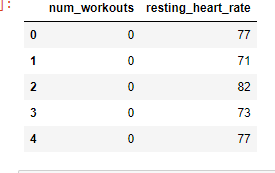

In [ ]:
# Perform the ANOVA
stats.f_oneway(group0, group1, group2, group3, group4)

In [ ]:
# #count of Asian in Hennepin county
# cdc_hennepin_asian_df = cdc_hennepin.loc[cdc_hennepin['Race'] == 'Asian']
# cdc_hennepin_asian_df

# # Count of Asian in Hennepin County
# cdc_hennepin_asian_count = cdc_hennepin_asian_df['Infections']
# cdc_hennepin_asian_count = list(cdc_hennepin_asian_count)
# cdc_hennepin_asian_count = cdc_hennepin_asian_count[0]

# print(f"Out of a reduced CDC dataframe, {cdc_hennepin_asian_count} asians in the Hennepin County responded they have been infected with Covid-19")

## %Asians in Anoka County

In [ ]:
#count of Asian in Anoka county
cdc_anoka = cdc_df.loc[cdc_df['County'] == 'ANOKA']
cdc_anoka

In [ ]:
sample_population_anoka = cdc_anoka['Infections'].sum()
print(f"Total sample population in Anoka County in this reduced dataset is {sample_population_anoka} according to the CDC.gov website")

In [ ]:
# count of Asian in Anoka county
# Count of Asian in Hennepin County
cdc_anoka_asian_count = cdc_anoka['Infections']
cdc_anoka_asian_count = list(cdc_anoka_asian_count)
cdc_anoka_asian_count = cdc_anoka_asian_count[0]
print(f"Out of the reduced CDC dataframe, {cdc_anoka_asian_count} asians in the Anoka County responded they have been infected with Covid-19")

In [ ]:
Asian_in_anoka = cdc_anoka_asian_count/sample_population_anoka*100
rounded_Asian_in_anoka = "{:.2f}".format(Asian_in_anoka)
print(f"{rounded_Asian_in_anoka}% of Asians are represented in the Anoka County in the CDC dataset")

## %Asians in Ramsey County

In [ ]:
cdc_ramsey = cdc_df.loc[cdc_df['County'] == 'RAMSEY']
cdc_ramsey

In [ ]:
sample_population_ramsey = cdc_ramsey['State'].count()
print(f"Total sample population in Ramsey County in this randomized dataset is {sample_population_ramsey} according to the CDC.gov website")

In [ ]:
#count of Asian in Ramsey county
cdc_ramsey_asian_df = cdc_ramsey.loc[cdc_ramsey['Race'] == 'Asian']
cdc_ramsey_asian_df

In [ ]:
# count of Asian in Ramsey county
cdc_ramsey_asian_count = cdc_ramsey_asian_df['State'].count()
cdc_ramsey_asian_count
print(f"Out of a randomized CDC dataframe, {cdc_ramsey_asian_count} asians in the Ramsey County responded they have been infected with Covid-19")

In [ ]:
Asian_in_ramsey = cdc_ramsey_asian_count/sample_population_ramsey*100
rounded_Asian_in_ramsey = "{:.2f}".format(Asian_in_ramsey)
print(f"{rounded_Asian_in_ramsey}% of Asians are represented in the Ramsey County in the CDC dataset")

In [ ]:
# Observed data in a CDC dataset
observed = pd.Series([rounded_Asian_in_hennepin,rounded_Asian_in_anoka,rounded_Asian_in_ramsey], index=["%Asians in Hennepin", "%Asians in Anoka", "%Asians in Ramsey"])

In [ ]:
# Create a data frame
observed_df = pd.DataFrame([observed]).T
observed_df

In [ ]:
# Create a data frame
df = pd.DataFrame([observed]).T

In [ ]:
expected = pd.Series([7.15, 4.55, 14.74], index=["%Asians in Hennepin", "%Asians in Anoka", "%Asians in Ramsey"])
expected = [7.15, 4.55, 14.74]
df[1] = expected
df[1]

In [ ]:
# Rename columns

df.columns = ["% of population infected with COVID-19 from CDC dataset", "Population Census"]
df

In [ ]:
# The degree of freedom is 3-1 = 2
# With a p-value of 0.05, the confidence level is 1.00-0.05 = 0.95.
critical_value = st.chi2.ppf(q = 0.95, df = 2)

In [ ]:
# The critical value
critical_value

In [ ]:
# Run the chi square test with stats.chisquare()
st.chisquare(df["% of population infected with COVID-19 from CDC dataset"], df["Population Census"])

In [ ]:
# Drop NaNs and then group by County and Race
cdc_df = cdc_df.dropna(how='any')
cdc_df = cdc_df[['County', 'Race', 'Infections']]
cdc_grouped_county = cdc_df.groupby(['County', 'Race'])
cdc_df = cdc_grouped_county.count()
cdc_df.reset_index(inplace=True)
cdc_df


# Pulling data using API with the help of JSON
## = Census Dataset =

### Drop NaN and compile totals by county and race

### Create poverty DataFrame based on US Census

In [23]:
# Poverty DataFrame By Race - 2020

url = "https://api.census.gov/data/2020/acs/acs5?get=NAME,B17001_002E,B17001A_002E,B17001B_002E,B17001C_002E,B17001D_002E,B17001E_002E,B17001F_002E,B17001G_002E,B17001H_002E,B17001I_002E&for=county:*&in=state:27&key={0}".format(census_key)
response = requests.request("GET", url)
response
poverty_df = json_to_dataframe(response)

# Split NAME into county & state
name = poverty_df['NAME'].str.split(",", n=1, expand=True)
COUNTY = poverty_df['County'] = name[0]
STATE = poverty_df['State'] = name[1]
poverty_df.drop(columns=["NAME"], inplace=True)
poverty_df['Caucasian2'] = poverty_df['B17001A_002E'].astype(int) - poverty_df['B17001I_002E'].astype(int)
poverty_df['Other'] = poverty_df['B17001F_002E'].astype(int) + poverty_df['B17001G_002E'].astype(int)

# Get the columns we want
poverty_df = poverty_df[['County', 'State','B17001_002E','Caucasian2', 'B17001B_002E','B17001C_002E','B17001D_002E','B17001E_002E','Other','B17001I_002E']]

# Rename columns to something intelligible
poverty_df = poverty_df.rename(columns={
    'B17001_002E':'Poverty Total',
    'Caucasian2':'Caucasian',
    'B17001B_002E':'African American',
    'B17001C_002E':'Native American',
    'B17001D_002E':'Asian',
    'B17001E_002E':'Hawaiian', # I had to change this from Native Hawaiian to Hawaiian for compatibility with the rest - Dom
    'B17001I_002E':'Hispanic' 
    })

# # Remove ...County from County in dataframe
poverty_df['County'] = poverty_df['County'].replace('County', '', regex=True)
# NOTE: The line above accidentally leaves a blank space at the end of these county names! That space caused a merge to fail
# on any of these counties because, for example, "AITKIN " is not the same as "AITKIN". 

# Remove any blank space that may be present at the begining or end of the county name
poverty_df['County'] = poverty_df['County'].str.strip()

# And then convert the county name to uppercase
poverty_df['County'] = poverty_df['County'].str.upper()

poverty_df['Year'] = 2020
#poverty_df.to_csv("../Project_1/population_in_poverty.csv")
poverty_df



NameError: name 'json_to_dataframe' is not defined

In [ ]:
# Choose only the columns we need
poverty_df = poverty_df[['County', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Other', 'Hispanic']]
poverty_df

In [ ]:
# Use melt to convert this into a format similar to the CDC data
poverty_df = poverty_df.melt(id_vars='County', value_vars=['Caucasian', 'African American', 'Native American', 'Asian', \
                                                    'Hawaiian', 'Other', 'Hispanic'], \
                                                     var_name='Race', value_name='Poverty')
poverty_gb = poverty_df.groupby(['County', 'Race'])
poverty_df = poverty_gb.sum()
poverty_df.reset_index(inplace=True)
poverty_df

### Function for quickly calling a DataFrame

### Create population DataFrame by county and race

In [ ]:
# Function for quickly assempling a DataFrame
def json_to_dataframe(response):
    return pd.DataFrame(response.json()[1:], columns=response.json()[0])

In [ ]:
# Population by county, by race
url = "https://api.census.gov/data/2020/acs/acs5?get=NAME,B03002_001E,B03002_003E,B03002_004E,B03002_005E,B03002_006E,B03002_007E,B03002_008E,B03002_009E,B03002_012E&for=county:*&in=state:27&key={0}".format(census_key)


response = requests.request("GET", url)
response
response_df = json_to_dataframe(response)
response_df = response_df.rename(columns={
    'B03002_001E': 'Population Total',
    'B03002_003E': 'Caucasian',
    'B03002_004E': 'African American',
    'B03002_005E': 'Native American',
    'B03002_006E': 'Asian',
    'B03002_007E': 'Hawaiian',
    'B03002_012E': 'Hispanic',
#     'B03002_005E': 'American Indian and Alaska Native alone'
})
response_df['Other'] = response_df['B03002_008E'].astype(int) + response_df['B03002_009E'].astype(int)
mn_pop_df = response_df

# Split NAME into county & state
name = mn_pop_df['NAME'].str.split(",", n=1, expand=True)
COUNTY = mn_pop_df['County']=name[0]
STATE = mn_pop_df['State']=name[1]
mn_pop_df.drop(columns=["NAME"], inplace=True)

# # Remove ...County from County in dataframe
mn_pop_df['County'] = mn_pop_df['County'].replace('County', '', regex=True)
# NOTE: The line above accidentally leaves a blank space at the end of these county names! That space caused a merge to fail
# on any of these counties because, for example, "AITKIN " is not the same as "AITKIN". 

# Remove any blank space that may be present at the begining or end of the county name
mn_pop_df['County'] = mn_pop_df['County'].str.strip()

# # Upper case for County
mn_pop_df['County'] = mn_pop_df['County'].str.upper()
mn_pop_df = mn_pop_df[['County', 'Population Total', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Hispanic', 'Other']]
mn_pop_df.to_csv("../Project_1/mn_population by race.csv")
mn_pop_df

In [ ]:
# # Edited merge_df for nan infections to be 0
# merged_df = pd.merge(mn_pop_df, poverty_df, on=['County', 'Race'])
# merged_df = pd.merge(merged_df, cdc_df, on=['County', 'Race'], how = "left")
# merged_df["Infections"] = merged_df["Infections"].fillna(0)
# merged_df

# # Convert all numerical values in merged_df from strings to int
# merged_df["Population"] = merged_df["Population"].astype(int)
# merged_df["Poverty"] = merged_df["Poverty"].astype(int)
# merged_df["Infections"] = merged_df["Infections"].astype(int)

# # Calculate poverty and infection rates
# poverty_rate = []
# infection_rate = []

# i = 0
# while i < len(merged_df):
#     if merged_df["Population"][i] == 0:
#         poverty_rate.append(0)
#         infection_rate.append(0)
#     else: 
#         poverty_rate.append(merged_df["Poverty"][i] / merged_df["Population"][i])
#         infection_rate.append(merged_df["Infections"][i] / merged_df["Population"][i])
#     i += 1
    
# merged_df["Poverty Rate"] = poverty_rate
# merged_df["Infection Rate"] = infection_rate

# merged_df[merged_df["County"] == "CROW WING"]

In [ ]:
mn_pop_df.columns

In [ ]:
# please obtain total population by race for all counties (MN)-08072022 COMMENT

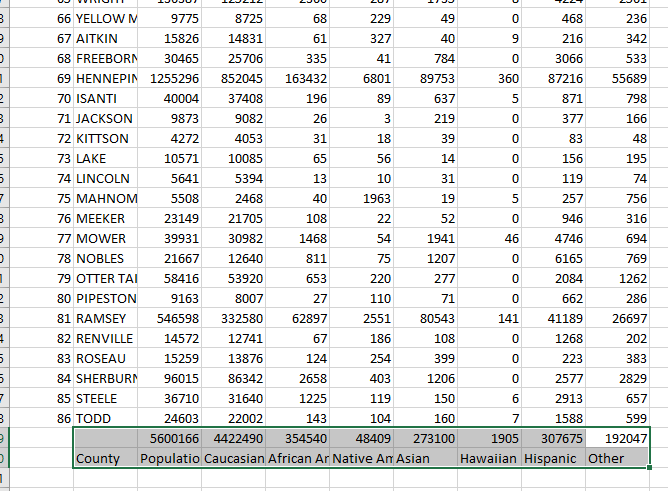

In [ ]:
#population by race infected with covid-19

mn_pop = mn_pop_df['Population Total']
mn_caucasian_pop = mn_pop_df['Caucasian']
mn_african_american_pop = mn_pop_df['African American']
mn_native_american_pop = mn_pop_df['Native American']
mn_asian_pop = mn_pop_df['Asian']
mn_hawaiian_pop = mn_pop_df['Hawaiian']
mn_hispanic_pop = mn_pop_df['Hispanic']
mn_other_pop = mn_pop_df['Other']


# caucasian_sum = mn_pop_df['Caucasian'].sum()
# caucasian_sum

# mn_pop_df.loc[  mn_pop_df['County'] == 'HENNEPIN'  ]

# mn_pop_df = mn_pop_df['Race'].value_counts()
# cdc_byrace_df

In [ ]:
mn_pop_list = list(mn_pop)
mn_pop_list
mn_caucasian_list = list(mn_caucasian_pop)
mn_caucasian_list
mn_african_american_list = list(mn_african_american_pop)
mn_african_american_list
mn_native_american_list = list(mn_native_american_pop)
mn_native_american_list
mn_asian_list = list(mn_asian_pop)
mn_asian_list
mn_hawaiian_list = list(mn_hawaiian_pop)
mn_hawaiian_list
mn_other_list = list(mn_other_pop)
mn_other_list
print(type(mn_pop_list[0]))

In [ ]:

# print([int(x) for x in mn_pop_list])
mn_pop_int_list = [int(x) for x in mn_pop_list]
mn_caucasian_int_list = [int(x) for x in mn_caucasian_list]
mn_african_american_int_list = [int(x) for x in mn_african_american_list]
mn_native_american_int_list = [int(x) for x in mn_native_american_list]
mn_asian_int_list = [int(x) for x in mn_asian_list]
mn_hawaiian_int_list = [int(x) for x in mn_hawaiian_list]
mn_other_int_list = [int(x) for x in mn_other_list]


print(type(mn_pop_int_list[0]))

In [ ]:
sum_mn_pop = sum(mn_pop_int_list)
sum_mn_caucasian = sum(mn_caucasian_int_list)
sum_mn_african_american = sum(mn_african_american_int_list)
sum_mn_native_american = sum(mn_native_american_int_list)
sum_mn_asian = sum(mn_asian_int_list)
sum_mn_hawaiian = sum(mn_hawaiian_int_list)
sum_mn_other = sum(mn_other_int_list)

print(sum_mn_pop)
print(sum_mn_caucasian)
print(sum_mn_african_american)
print(sum_mn_native_american)
print(sum_mn_asian)
print(sum_mn_hawaiian)

In [ ]:
percent_mn_caucasian = sum_mn_caucasian/sum_mn_pop*100
percent_mn_african_american = sum_mn_african_american/sum_mn_pop*100
percent_mn_native_american = sum_mn_native_american/sum_mn_pop*100
percent_mn_asian = sum_mn_asian/sum_mn_pop*100
percent_mn_hawaiian = sum_mn_hawaiian/sum_mn_pop*100
percent_mn_other = sum_mn_other/sum_mn_pop*100

print(percent_mn_caucasian)
print(percent_mn_african_american)
print(percent_mn_native_american)
print(percent_mn_asian)
print(percent_mn_hawaiian)
print(percent_mn_other)

In [ ]:
#Population in Hennepin County by race


mn_pop_hennepin_df = mn_pop_df.loc[  mn_pop_df['County'] == 'HENNEPIN'  ]
mn_pop_hennepin_df

In [ ]:
mn_pop_hennepin_asian_count = mn_pop_hennepin_df['Asian']
mn_pop_hennepin_asian_count(index = False)
print(mn_pop_hennepin_asian_count)
# mn_pop_hennepin_asian_count = mn_pop_hennepin_asian_count.astype(str).astype(int)


# mn_pop_hennepin_asian_count.reset_index()

mn_pop_hennepin_asian_count = pd.DataFrame(mn_pop_hennepin_asian_count)
# mn_pop_hennepin_asian_count
# mn_pop_census_hennepin_asian_per_df = 

In [ ]:
mn_pop_hennepin_total_population = mn_pop_hennepin_df['Population Total']
mn_pop_hennepin_total_population = mn_pop_hennepin_total_population.astype(str).astype(int)
mn_pop_hennepin_total_population

In [ ]:
mn_pop_census_hennepin_asian_per = mn_pop_hennepin_asian_count/mn_pop_hennepin_total_population*100
mn_pop_census_hennepin_asian_per = round(mn_pop_census_hennepin_asian_per, 2) 
mn_pop_census_hennepin_asian_per

In [ ]:
#Population in Anoka County by race
mn_pop_anoka_df = mn_pop_df.loc[  mn_pop_df['County'] == 'ANOKA'  ]
mn_pop_anoka_df

In [ ]:
mn_pop_anoka_asian_count = mn_pop_anoka_df['Asian']
mn_pop_anoka_asian_count = mn_pop_anoka_asian_count.astype(str).astype(int)
mn_pop_anoka_asian_count
# mn_pop_census_hennepin_asian_per_df = 

In [ ]:
mn_pop_anoka_total_population = mn_pop_anoka_df['Population Total']
mn_pop_anoka_total_population = mn_pop_anoka_total_population.astype(str).astype(int)
mn_pop_anoka_total_population

In [ ]:
mn_pop_census_anoka_asian_per = mn_pop_anoka_asian_count/mn_pop_anoka_total_population*100
mn_pop_census_anoka_asian_per = round(mn_pop_census_anoka_asian_per, 2) 
mn_pop_census_anoka_asian_per

In [ ]:
#Population in Ramsey County by race
mn_pop_ramsey_df = mn_pop_df.loc[  mn_pop_df['County'] == 'RAMSEY'  ]
mn_pop_ramsey_df

In [ ]:
mn_pop_ramsey_asian_count = mn_pop_ramsey_df['Asian']
mn_pop_ramsey_asian_count = mn_pop_ramsey_asian_count.astype(str).astype(int)
mn_pop_ramsey_asian_count
# mn_pop_census_hennepin_asian_per_df = 

In [ ]:
mn_pop_ramsey_total_population = mn_pop_ramsey_df['Population Total']
mn_pop_ramsey_total_population = mn_pop_ramsey_total_population.astype(str).astype(int)
mn_pop_ramsey_total_population

In [ ]:
mn_pop_census_ramsey_asian_per = mn_pop_ramsey_asian_count/mn_pop_ramsey_total_population*100
mn_pop_census_ramsey_asian_per = round(mn_pop_census_ramsey_asian_per, 2) 
mn_pop_census_ramsey_asian_per

### Coordinates for heat map -- if time permits

In [ ]:
# Get the coordinates of counties in MN
url = "https://en.wikipedia.org/wiki/User:Michael_J/County_table"

table = pd.read_html(url)
df = table[0]
Counties = df.loc[df['State'] == "MN", : ]
counties_df = Counties[['County [2]', 'Latitude', 'Longitude']]
counties_df#.to_csv("../Project_1/county_geo.csv")  

In [ ]:
# Choose only the columns we need
mn_pop_df = mn_pop_df[['County', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Other', 'Hispanic']]
mn_pop_df


In [ ]:
# Use melt to convert this into a format similar to the CDC data
pop_df = mn_pop_df.melt(id_vars='County', value_vars=['Caucasian', 'African American', 'Native American', 'Asian', \
                                                      'Hawaiian', 'Other', 'Hispanic'], \
                                                      var_name='Race', value_name='Population')
pop_gb = pop_df.groupby(['County', 'Race'])
pop_df = pop_gb.sum()
pop_df.reset_index(inplace=True)
pop_df

### Merge the datasets

In [ ]:
merged_df = pd.merge(pop_df, poverty_df, on=['County', 'Race'])
merged_df = pd.merge(merged_df, cdc_df, on=['County', 'Race'])
merged_df

## Practice codes

In [ ]:
#old
url = "https://api.census.gov/data/2019/acs/acs5?get=NAME,B19013_001E,B01003_001E,B01002_001E,B19301_001E,B17001_002E,B23025_005E,B02001_001E,B02001_002E,B02001_003E,B02001_005E,B02001_006E,B02001_007E,B02001_004E&for=county:*&in=state:27&key={0}".format(census_key)
response = requests.request("GET", url)

census_df = json_to_dataframe(response)
# Split NAME into county & state
name = census_df['NAME'].str.split(",", n=1, expand=True)
COUNTY = census_df['County']=name[0]
STATE = census_df['State']=name[1]
census_df.drop(columns=["NAME"], inplace=True)

# Rename columns to something intelligible
census_df = census_df[['County', 'State', 'B19013_001E', 'B01003_001E', 'B01002_001E', 'B19301_001E', 
                       'B17001_002E', 'B23025_005E', 'B02001_001E', 'B02001_002E', 'B02001_003E', 'B02001_005E', 'B02001_006E', 'B02001_007E', 'B02001_004E']]
census_df = census_df.rename(columns={
    'B01003_001E':'Population',
    'B01002_001E': 'Median Age',
    'B19013_001E': 'Median Household Income',
    'B19301_001E': 'Per Capita Income',
    'B17001_002E': 'Poverty Count',
    'B23025_005E': 'Unemployment Count',
    'B02001_001E': 'Race',
    'B02001_002E': 'Caucasian/White',
    'B02001_003E': 'African American',
    'B02001_005E': 'Asian',
    'B02001_006E': 'Native Hawaiian and Other Pacific Islander alone',
    'B02001_004E': 'American Indian and Alaska Native',
    'B02001_007E': 'Some other Race'
})

# Remove ...County from County in dataframe in each row
census_df['County'] = census_df['County'].replace('County', '', regex=True)

census_df

In [ ]:
# create data
# df = pd.DataFrame({'Column 1':[rounded_Asian_in_hennepin,rounded_Asian_in_anoka,rounded_Asian_in_ramsey],
                     
#                    'Column 2':[7.15, 4.55, 14.74]})
# df

In [ ]:
# total = 0
 
# # creating a list
 
# # Iterate each element in list
# # and add them in variable total
# for element in range(0, len(mn_pop_list)):
#     total = total + mn_pop_list[element]

In [ ]:
df= pd.DataFrame({'number': np.random.randint(1, 100, 10)})
df['bins'] = pd.cut(x=df['number'], bins=[1, 20, 40, 60,
                                          80, 100])
print(df)
 
# We can check the frequency of each bin
print(df['bins'].unique())

In [ ]:
import pandas as pd
import numpy as np
 
df = pd.DataFrame({'number': np.random.randint(1, 100, 10)})
df['bins'] = pd.cut(x=df['number'], bins=[1, 20, 40, 60, 80, 100],
                    labels=['1 to 20', '21 to 40', '41 to 60',
                            '61 to 80', '81 to 100'])
 
print(df)
 
# We can check the frequency of each bin
print(df['bins'].unique())

# -------------------------------------**Sung** Work Ends Here-----------------------------------